# Finding treatment effect on cancer using time periods before and after treatment

## Method Description
### Summary
This method finds the causal effect of drug on cancer development using a self-matching approach, where observations of a population in a treatment time period are compared to those in an earlier time period.  We take advantage of the fact that individuals are observed over multiple years to assess whether the rate of cancer incidence in the time after drug treatment is more or less than would be expected.  

The first step is to estimate how many cancers would be expected to develop if the drug has no influence. The temporal observations allow us to estimate the potential outcome for each person who took the drug, if no drug had been administered, using the outcome in unexposed time before drug treatment.  From this first estimate, we must account for age (the person is a little older in the time after drug treatment), and for effect of cancer on prescription of each drug.

Once we have an estimate of expected number of cancers, we can compare this against the observed number of cancers under treatment to get a risk ratio. This risk ratio provides our estimate of the causal effect of drug on cancer development.

### Definitions
- *Time periods*: this method is based on observations of cancer onset in a person over time periods defined by drug treatment. The two periods used are defined below.
- *Treated time* is a period during and after drug treatment.  To account for the fact that cancer may have a lag in developing, and may be slow to be detected, we include a window (`effect_window`, currently set to 2 years) of time after drug treatment.  
- *Unexposed time* is a time period of similar length, occurring immediately before the first recorded drug treatment.  If a patient does not have such a time period observed, this patient is not included in the analysis.
- *Cancer* is defined as the first diagnosis of cancer.  We assume that any further diagnoses of cancer are re-diagnoses related to the first diagnosis.  Thus, each person can have at most *one* first diagnosis of cancer, and this may occur in either the exposed time, unexposed time, or neither.

### Description of steps in the approach
Each step in the approach is linked to more detail in the "Method Detail" section (and the details each link back to their descriptions).

**[1. Observe treated and unexposed periods for drug takers](#gather_data)** <a id='gather_data_d'></a>: The first step gathers incidence of cancer *c* for people who took a drug *d*, and are observed for an adequate amount of time both before and after treatment. Any patients without this amount of time observed are removed.  Then, for each person, we examine two time periods: unexposed time, and treated time.  A point to emphasize is that people can only have onset of cancer in one of the two time periods, so for a particular person the two time periods have a dependence. However, our goal is to model the population incidence of cancer, and without any effect of treatment, the incidence of cancer in the two time periods should be independent. Thus, we assume that across the drug-taking population for a given drug, the unexposed time provides a good estimate of the rate of cancer development in this population in treated time.

These time periods are illustrated in the Figure below.  The figure illustrates a medical history for one patient, observed from age 46 to 52, who received two prescriptions of drug *d* at the ages of 48 and 49.  

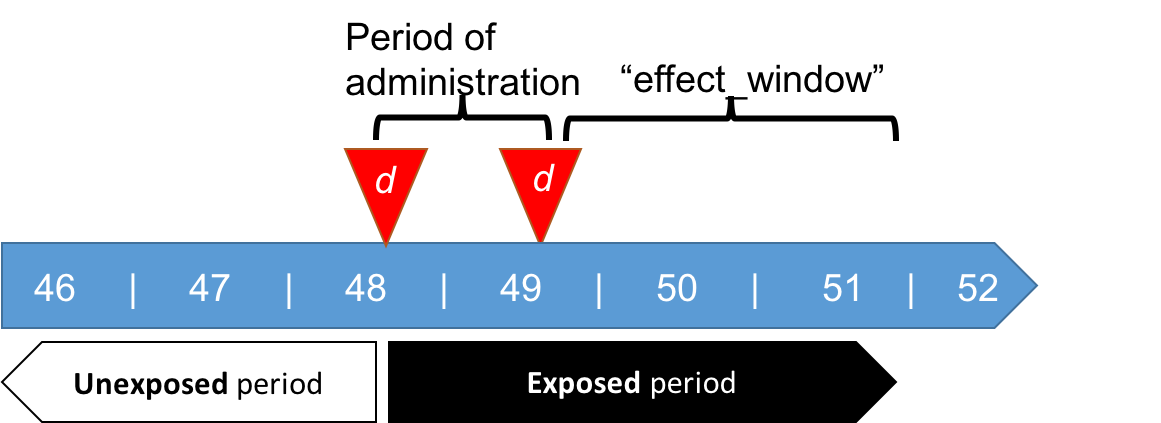

In [14]:
Image(filename='png/time_periods.png',width=600)

**[2. Create an estimate of expected number of cancers in the exposed period, based on the unexposed period](#expected_cancers)**:  Estimating the expected number of cancers that would happen under drug exposure with no causal effect of the drug on cancer incidence involves three controls.  The first control was performed above, by observing a  sample of the population pre-treatment, that should contain the expected distribution of the number of cancers, if the drug has no effect. Next, we create an age-adjusted estimate of the expected number of cancers in the treated period, $e_{c,d}$ (2.1).  Finally, we use the age-adjusted estimate to create a reverse-causality-adjusted estimate that is adjusted for the causality of cancer on drug prescription $e'_{c,d}$ (2.2).

**[2.1. Controlling for age](#age_control)**<a id='age_control_d'></a>:  Since people are a little older in the exposed period than in the unexposed period, we must adjust this expected number of cancers for the age difference.  To do this, we fit a linear model using the Unexposed period.  This linear model should represent the rate of cancer in the drug-taking population, without any effect of the drug.  We use a log-linear Poisson model in order to model the rate of cancer across a variable number of weeks observed for each person, and varying age observed.  Then, we use the model to predict the number of cancers that should be observed in the Exposed periods, under the same model as in the Unexposed period.  This yields $e_{c,d}$, a distribution of the age-adjusted number of cancers.

**[2.2. Controlling for the causality of cancer on drug prescription](#cancer_causality)**: Since our method is based on disproportional incidence of cancer in the exposed versus unexposed period, we must account for the fact that cancer itself will influence incidence of drug prescription.  For example: Breast Cancer causes less prescription of some drugs, such as estrogens, so fewer cancer cases will be present in the time period before estrogen is prescribed. There are probably many people with cancer who would have been prescribed estrogen, but cancer caused them to not be prescribed estrogen. Conversely, cancer causes prescription of some drugs (ie, chemotherapy). Under our assumption that the unexposed time holdes the distribution of cancer for this population, this would lead to an inflated estimate of th incidence of cancer.  We want to account for this by estimating the association of cancer and a drug, if the drug incidence relationship is only caused by cancer, not vice-versa, and then adjusting our expected cancer rates. 

- **[2.2.1. Estimating the causality of cancer on drug prescription](#rrx)** <a id='rrx_d'></a>: To assess the causality of cancer on prescribing, we take a similar approach as to the reverse question: we count how many people were prescribed a drug in the period before cancer, versus being  prescribed the drug after cancer.  
    - Our measure of the influence of cancer on drug is the **Relative Prescribing Rate = $RRx_{c,d}$**, a ratio of prescription before versus after cancer. Even if a drug increases the risk of cancer (d -> c), if cancer does not cause decreased prescription of the drug (c -| d), then we assume there should be no particular reason that a drug would be prescribed more before than after cancer.  (*Note: I'm not totally decided if this is OK..*).  
    - In order to compare prescription rates in the period before versus after cancer, we must control for the different calendar year and age of people in the two periods. This is slightly different what we did in 2.1, because drug prescription has a sharper dependency on year, and probably does not follow a smooth linear/quadratic model.  Also, the first study years can never be observed in the "after cancer" period, excluding a categorical model fitted on the "after cancer" period.  Thus, we model incidence of drug prescription as a function of year and age across all people.  We compare the prescriptions observed before and after cancer to the value estimated from this function to estimate $RRx_{c,d}$.

- **[2.2.2. Adjusting the expected rate of cancers](#rrx_adjustment)** <a id='rrx_adjustment_d'></a>: Once we have the $RRx_{c,d}$, which we model as a distribution, we use this to further adjust our age-adjusted expected number of cancers.  For example, if the $RRx_{breast\ cancer, estrogen}$ = 10, for every 10 people taking estrogen before breast cancer, there is one person taking estrogen after breast cancer.  Breast cancer causes less estrogen to be prescribed. Then, in the population of women taking estrogen, for every one breast cancer that happens before estrogen is given, you would expect 10 breast cancers after estrogen is given, simply due to the causality of breast cancer on estrogen prescription. Therefore, the product of the age-adjusted expected number of cancers in the exposed period ($e_{c,d}$), and the $RRx_{c,d}$, gives the final estimate of expected number of cancers, $e'_{c,d}$.  This is also modeled as a distribution.

**[3. Estimating relative risk of cancer under treatment](#treatment_effect)** <a id='treatment_effect_d'></a>:  Once we have our expected number of cancers, we can perform the disproportionality analysis. The goal is to estimate the drug effect $M_{c,d}$, which is a risk ratio for developing cancer after the drug is given.  The previous steps gave us a distribution of $e'_{c,d}$, and we can assume a fixed prior distribution for $M_{c,d}$.  Here, we take a Bayesian approach to sample from these distributions and estimate the distribution of $M_{c,d}$. The outer confidence interval of $M_{c,d}$ gives us our effect estimates.

## Method detail
The analysis estimates the expected number of cancers of type *c* for drug *d*, and it compares this to the observed number of cancers after treatment with *d*.   
### 1. Self-controlled cancer incidence<a id='gather_data'></a> [(description)](#gather_data_d)
We choose a window after treatment called `effect_window`.  For each person who took the drug **and** is observed for the full amount of time, we define two time periods:
- ** *t* (treated)**: the total time that drug was administered, plus `effect_window` time after the last administration, if the patient has this amount of time observed. 
- ** *u* (unexposed)**: the same length of time before drug was administered, or a time period of least of length `effect_window`.

This yields for each person *i* who took *d* and is observed sufficiently the following variables, defined for time periods $p \in {u, t}$:

- $cancer_{i,c,d,p}$ :  binary, if cancer onset occurred in time period
- $weeks_{i,d,p}$: number of weeks observed in time period
- $age_{i,d,p}$: mean age during time period

This also yields the Observed number of cancers in the treated time: $n_{c,d} = \sum_i { cancer_{i,c,d,t} } $

### 2. Estimate expected number of cancers<a id='expected_cancers'></a>

#### 2.1 Controlling for age [(description)](#age_control_d) <a id='age_control'></a>
We create a model of the rate of cancer incidence for each drug *d*, for the **unexposed** time *u*. This should model the fact that each drug is given to a different patient population, with a cancer rate that is dependent on age. I fit a poisson model for age effects, with a "weeks exposed" offset.  Note that the outcome variable (cancer) is restricted to the values (0, 1), so it cannot strictly follow a Poisson distribution.  However, the probability of getting cancer in a given two year period is very low, and the probability of 2 or more counts under this distribution thus tends towards zero, so the Poisson forms a reasonable model.  

The Poisson rate parameter is modeled: 
$$ cancer_{i,c,d,u} \sim weeks_{i,d,u} * exp[{\beta_{0,c,d} + \beta_{1,c,d}*age_{i,d,u} + \beta_{2,c,d}*age_{i,d,u}^2 }]$$

Then, use the fitted unexposed model to predict rate of cancers in the **treated** time, for patients with no cancer before exposure:
$$ e_{c,d} = \sum_{i \in cancer_{i,d,u}==0} { weeks_{i,d,t}* exp[{\beta_{0,c,d} + \beta_{1,c,d}*age_{i,d,t} + \beta_{2,c,d}*age_{i,d,t}^2 } ] } $$

However, this model is probably noisy.  Empirically, we found bootstrap samples of the unexposed period for a given drug show a variance of 5%.  Instead, we can create a distribution of $e_{c,d}$ based on these bootstrap samples.  

#### 2.2 Causality of cancer -> Drug<a id='cancer_causality'></a>
First, we estimate the effect of cancer on drug prescribing, $RRx_{c,d}$ (2.2.1).  Then, we use this to create an adjusted expected number of cancers, $e'_{c,d}$ (2.2.2).

#### 2.2.1  Estimating the causality of cancer on drug prescription <a id='rrx'></a> [(description)](#rrx_d)
Our estimate of the causality of cancer on drug prescription is the **Relative Prescribing Rate = $RRx_{c,d}$** before versus after cancer.  To assess the causality of cancer, we can consider a cancer-centric (rather than drug-centric) view.  We collect drug-prescribing information for people who had cancer, for the two years before and after cancer, for patients with both periods observed.  We assume that if cancer has no effect on drug-prescribing, then the rate after cancer will be a good estimate of the rate before cancer.

This yields the following variables for each person with cancer who took the drug, for the periods $p \in {b, a}$ (*b*, before; *a*, after):  
- $days_{i,c,d,p}$ : number of days of prescription of drug *d* in the period 
- $age_{i,c,p}$: age when the period was observed
- $year_{i,c,p}$: year when the period was observed

So we can calculate:
- $B_{c,d} =  \sum_i days_{i,c,d,b} $ : observed prescription of *d* before cancer
- $A_{c,d} =  \sum_i days_{i,c,d,a} $: observed prescription after of *d* after cancer

However, $A_{c,d}$ and $B_{c,d}$ are observed in different years and ages of patients.  


Thus, we model incidence of drug, for a given year *y* and age *z*.  To do this, we collect information for every combination *i* of age (15 age bins) and year (12 years):

- $age_i$: a dummy vector indicating which age bin is represented, such that $\sum_{z} age_{i,z} = 1 $,
- $year_i$: indicating which year, $\sum_{y} year_{i,y} = 1 $
- $totalPeople_i$: a count of how many women, in the whole Marketscan population, are observed at that age and year
- $rx_{i,d}$: how many of the total are taking drug *d*.

(Note, this model is only for women so far.  Gender could be another variable.)

Then, we can fit a model across the combinations *i*, assuming there is no interaction between age and year:
$$ rx_{i,d} \sim totalPeople_{i} * exp[{\beta_{0,d} + \sum_{z \in ages} \beta_{z,d}*age_{i,z} + \sum_{y \in years} \beta_{y,d}*year_{i,y} }]  $$

Note that this function is independent of cancer or the cancer population.  Then we can estimate the expected number of prescriptions in the two periods: 
$$A'_{c,d} = \sum_{i} exp[{\beta_{0,d} + \sum_{z \in ages} \beta_{z,d}*age_{i,c,a} + \sum_{y \in years} \beta_{z,y}*year_{i,c,a} }] $$
$$B'_{c,d} = \sum_{i} exp[{\beta_{0,d} + \sum_{z \in ages} \beta_{z,d}*age_{i,c,b} + \sum_{y \in years} \beta_{z,y}*year_{i,c,b} }] $$
 

This allows us to create an estimate of the expected incidence of drug before cancer, given how much drug was prescribed after cancer, and how much drug is expected prescribed per observation of a patient in year *y* at age *z*.  This estimate describes the expected prescription, if cancer had no effect on the rate of drug prescription:
$$ D_{c,d} = A_{c,d}*{B'_{c,d} \over A'_{c,d} }$$

Now, we can calculate $RRx_{c,d}$ by comparing the adjusted expected rate of prescription before cancer, $D_{c,d}$, to the observed rate, $B_{c,d}$.

A Bayesian approach called the Gamma-Poisson Shrinker, formulated by DuMouchel for adverse events, compares observed incidence versus expected, to calculate an estimate of the ratio, putting a prior distribution on the ratio.  The parameters of this prior distribution ($\gamma_c, \phi_c $) are learned using empirical Bayes.
So if:
-  $\mu_{c,d}$ represents the rate parameter for prescription of *d* before cancer *c*, then $ B_{c,d} \sim Poisson(\mu_{c,d}) $ 
- $ RRx_{c,d}  = { \mu_{c,d} \over D_{c,d} } $, with a prior distribution given by $ RRx_{c,d} \sim \Gamma(\gamma_c, \phi_c) $ 
- So we can model incidence of $B_{c,d}$ as a Gamma-Poisson mixture: $ B_{c,d} \sim Poisson(\mu_{c,d}) = Poisson( RRx_{c,d} * D_{c,d} ) $
- Integrating out $RRx_{c,d}$, then: $$ B_d \sim NegativeBinomial(\gamma_c, { D_{c,d} \over {\phi_c + D_{c,d} }}) $$. 

Using the observed values of $D_{c,d}$ and $B_{c,d}$ across all drugs for this cancer, we can maximize the likelihood using this distribution to get empirical bayes estimates for $\alpha_c, \beta_c $, the prior parameters for cancer *c*. 

Then, you can get the posterior distribution:  $$ RRx_{c,d} \sim \Gamma(\gamma_{c} + B_{c,d}, \phi_{c} + D_{c,d}) $$
 
If the disparity in drugs is only caused by cancer (rather than the drugs causing a change in cancer), then we use the following relationship:

$$ RRx_{c,d} = {Rx_d\ before\ Cancer_c \over Rx_d\ after\ cancer_c} = { Cancer_c\ after\ Rx_d \over Cancer_c\ before\ Rx_d }$$

Where the right-most term represents the expected ratio of cancers in the Exposed period as compared to the unexposed period. 

#### 2.2.2 Adjusting the expected rate of cancers [(description)](#rrx_adjustment_d) <a id='rrx_adjustment'></a>
Now, we have two distributions:
- $e_{c,d}$:  the age-adjusted expected number of cancers, distributed across bootstrap samples of the Unexposed period of a drug (2.1)
- $RRx_{c,d}$: the relative prescribing ratio for a drug *d*, before versus after cancer *c*, with a Gamma distribution. (2.2.1)

Then, we want to find $e'_{c,d}$, the corresponding number of cancers expected to occur after Rx, adjusting for Rx incidence caused by cancer, using the relationship in 2.2.1.  Since $e'_{c,d}$ represents the rate of cancers occurring after drug, for a given number of cancers occurring before a drug, this is a mixture of the distribution of the number of cancers occurring before the drug, and the the distribution of the disproportional prescribing rate after versus before cancer:
$$ e'_{c,d} \sim  Poisson(e'_{c,d} | RRx_{c,d}*e_{c,d})*\Gamma(RRx_{c,d} | \gamma_c + B_{c,d}, \phi_c + D_{c,d}) $$

Integrating out the distribution of $RRx_{c,d}$ gives us a distribution of expected number of cancers after adjusting  for age and for cancer caused by drug:
    $$ e'_{c,d} \sim NegBin(\gamma_c + B_{c,d}, { e_{c,d} \over { \phi_c + D_{c,d} + e_{c,d} } }) $$
 

### 3. Estimating relative risk of cancer under treatment  <a id='treatment_effect'></a> [(description)](#treatment_effect_d)

Now we want to integrate over that to estimate the Treatment Effect of a drug on cancer, or Relative Risk **$M_{c,d}$**:
- **$M_{c,d}$** = the Relative Risk we want to estimate for drug *d*, cancer *c*:  $ M_{c,d} = { exposed\ cancer\ risk \over unexposed\ risk } $
- **$n_{c,d}$** = observed number of cancers after treatment (from Step 1)  in people who did not get cancer before treatment.  

Similar to before we can model this as the result of a Poisson process using 
    $$ n_{c,d} \sim Poisson( expectedCancer * exposureRisk ) = Poisson( e'_{c,d} * M_{c,d} ) $$ 
    
$e'_{c,d}$ and $M_{c,d}$ should be independent, so the joint distribution could be: 
    $$ P(n_{c,d}, e'_{c,d}, M_{c,d}) \sim Poisson(N_{c,d} | e'_{c,d} * M_{c,d})* NegBin(e'_{c,d} | \gamma_c + B_{c,d},  { e_{c,d} \over {\phi_c + D_{c,d} + e_{c,d}}}) * \Gamma(M_{c,d} | \lambda_0, \delta_0) $$

#### 3.1 Distribution of $M_d$
Given a fixed prior $\Gamma(\lambda_0, \delta_0)$ distribution for $M_{c,d}$, and a given $e'_{c,d}$, we can get the distribution of $ M_{c,d} \sim \Gamma( n_{c,d} + \lambda_0, e'_{c,d} + \delta_0 ) $

We can do a sampling approach to estimate $M_d$:
- Sample $e_{c,d}$ using bootstraps to estimate the linear model for cancer incidence
- Sample $e'_{c,d}$ using the negative binomial with $e_d$ given above
- Then, get the 90% CI of $M_{c,d}$, across the distribution of $e'_{c,d}$, with the fixed prior for *M*

In [2]:
from IPython.display import Image